In [22]:
import os
import sys
import time
import itertools

In [23]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize

In [24]:
import autograd
import autograd.numpy as ag_np

from autograd.scipy.special import expit as ag_logistic_sigmoid

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

In [26]:
# Custom visualization routines
import visuals

# Wrappers around scipy.optimize solvers
import solvers

# Utility functions to compute true TP/FP/TN/FN and predict score for each example
from binary_clf_utils import calc_binary_clf_perf, calc_decision_score

In [27]:
# Load toydata generating module
import toydata

In [28]:
# Load modeling modules
import BCE
import SurrogateSigmoid
import SurrogateHinge

In [29]:
# import Fathony and Kolter's adversarial prediction helper functions
import torch
from AdversarialPredictionUtils import LinearClassifier, RecallGvPrecision, TabularDataset
from ap_perf import PerformanceMetric, MetricLayer
from torch.utils.data import Dataset, DataLoader, random_split

In [30]:
figsize = (5, 5)

## Create Toy Data

In [31]:
x_ND, y_N, x_pos_ND, y_pos_N, x_neg_ND, y_neg_N = toydata.create_toy_dataset()

In [32]:
N = x_ND.shape[0]
Npos = x_pos_ND.shape[0]
Nneg = x_neg_ND.shape[0]

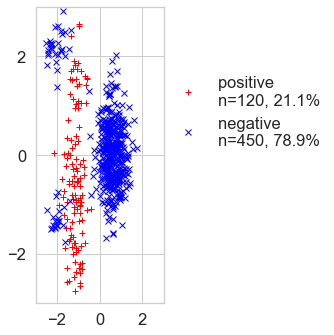

In [55]:
f, axs = plt.subplots(1, 1, figsize=figsize)
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+', label='positive \nn=%2d, %.1f%%' % (Npos, 100*Npos/N))
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx', label='negative \nn=%2d, %.1f%%' % (Nneg, 100*Nneg/N))
axs.set_xlim([-3, 3]); axs.set_xticks([-2, 0, 2]);
axs.set_ylim([-3, 3]); axs.set_yticks([-2, 0, 2]);
axs.legend(
    loc='lower left',
    bbox_to_anchor= (1.01, 0.5),
    borderaxespad=0,
    frameon=False);

plt.tight_layout()
f.savefig(os.path.join('images', 'toy_example.png'))

## Plan of Attack


We'd like to train a linear classifier on the toy dataset above.

We want this classifier to achieve some desired precision (set in the `alpha = ____` line below).

We wish to try 3 different objectives for solving this problem:

* BCE : Binary cross entropy
* SurrogateHinge : From Eban et al.
* SurrogateSigmoid : From this work

BCE is a convex problem, so we can just run it once and report how well it does.

The other two methods (Hinge, Sigmoid) are designed for a constrained optimization problem:

$$
    \text{argmin}_w f(w)
    \\
    \text{s.t.}~~ g(w) < 0
$$
where each one defines different lower/upper bounds used to define $f$ and $g$.

We transform the tough constrained problem into a standard unconstrained problem via the penalty method as:

$$
    \text{argmin}_w f(w) + \lambda \cdot \text{max}(g(w), 0)
$$

We'll try several logarithmically increasing values of $\lambda$.

At each $\lambda$, we'll try many initializations (20), drawing each entry of $w$ uniformly between -3 to +3.

Across all runs (all $\lambda$ and all initializations) we want to keep the best run.



We need to use a "common" loss across all tried $\lambda$ values so that solutions can be compared fairly. We'll grade each result's candidate solution $w'$ in terms of the following loss:

$$
    f(w') + 100000 \cdot  \text{max}(g(w'), 0)
$$

This way, any solution that does not satisfy the constraint is sure to have a huge value (here, minimization is good).

The function `calc_common_loss_from_ans_dict` defined below computes this "common" loss.

In [34]:
def calc_common_loss_from_ans_dict(ans_dict):
    k = ans_dict
    return (k['f']
        + 100000 * np.maximum(0.0, k['g']) 
        + (np.inf if k['recall']<0.01 else 0.0) # avoid degenerate solutions with no recall
       )

## Define problem to solve

In [35]:
alpha = 0.9      # precision to enforce. Used by both Sigmoid and Hinge methods

# Hyperparameters for our Sigmoid method                  
delta = 0.035     # small lift to zero-one loss to allow positive TP lower bounds
gamma = 7.0      # tolerance for the height of the sigmoid bounds (gamma * delta)
epsilon = 0.75    # tolerance for the width of the sigmoid bounds

In [36]:
sigm__lamb_candidate_values = np.logspace(-3, 3, 5)
hin__lamb_candidate_values = np.logspace(-5, 5, 20)

hin__lamb_candidate_values

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

In [37]:
random_state = 4233#8675309

## Try standard Binary Cross Entropy

In [38]:
bce_loss, bce_grad = BCE.make_loss_and_grad_for_dataset(x_ND, y_N)

In [39]:
best_w_D__bce, best_loss__bce, best_issat__bce, answers__bce = solvers.solve_minimimization_multiple_tries_with_lbfgs(
    x_ND, y_N, bce_loss, bce_grad, n_inits=5, alpha=alpha, random_state=random_state)

init 00   -1.81  -2.22  -1.61 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 01   -2.45   2.08   1.71 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 02    1.91   0.30  -1.61 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 03    0.84  -0.52   1.81 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 04    0.34  -0.45   2.69 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68


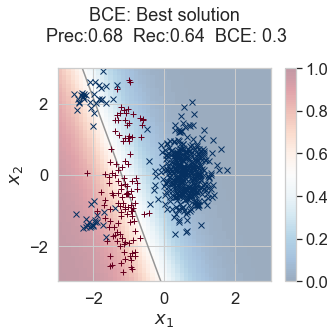

In [52]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_w_D__bce, x_ND, y_N,
    title_str='BCE: Best solution',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

plt.tight_layout()
plt.savefig(os.path.join("images", "BCE_plus_threshold_search_solution.png"))

## Proposed sigmoid surrogate loss

In [42]:
n_inits = 20

best_w_D__sigm_by_lam = {}
best_loss__sigm_by_lam = {}
answers__sigm_by_lam = {}

for lamb in sigm__lamb_candidate_values:
    print("")
    print("Lambda %.3g" % lamb)
    print("-----------")
    sigm_loss, sigm_grad, sigm_tp, sigm_fp = SurrogateSigmoid.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001,
        gamma=gamma, delta=delta, epsilon=epsilon)
    
    best_w_D__sigm_by_lam[lamb], best_loss__sigm_by_lam[lamb], _, answers__sigm_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, sigm_loss, sigm_grad,
            calc_FPUB=sigm_fp,
            calc_TPLB=sigm_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True,
            alpha=alpha, gamma=gamma, delta=delta, lamb=lamb)


Lambda 0.001
-----------
FPUB
slope      6.8507692
intercept  1.5950491
TPLB
slope      6.8507686
intercept -3.5430273
init 00   -1.81  -2.22  -1.61 | loss     -0.26131 final w  -10.41  -0.58  -3.69 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 149.4 FP =  53.0
  surrogate TP   >= 149.4 FP<=  66.4
  surrogate  f     -149.39659  g   448.56985  l2   0.00109
init 01   -2.45   2.08   1.71 | loss     -0.26132 final w  -17.59  -0.93  -6.44 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 149.4 FP =  53.0
  surrogate TP   >= 149.4 FP<=  66.0
  surrogate  f     -149.39998  g   444.72894  l2   0.00310
init 02    1.91   0.30  -1.61 | loss      0.00000 final w    0.99   0.15  -2.65 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  29.4 FP =   0.0
  surrogate TP   >=   0.0 FP<=   0.0
  surrogate  f     -0.00000  g   0.42230  l2   0.00001
init 03    0.84  -0.52   1.81 | loss     -0.25352 fin

init 09   -2.13   0.19   1.11 | loss     -0.23927 final w  -45.96  -2.94 -21.40 | recall 1.00 prec 0.71
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 149.4 FP =  50.0
  surrogate TP   >= 149.4 FP<=  62.3
  surrogate  f     -149.39836  g   410.92079  l2   0.02121
init 10   -1.01   0.78   0.34 | loss     -0.23744 final w  -18.90  -0.39  -6.97 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 149.4 FP =  53.0
  surrogate TP   >= 149.4 FP<=  66.0
  surrogate  f     -149.39902  g   444.47488  l2   0.00358
init 11   -0.03   1.36   1.82 | loss      0.00934 final w   -0.86   0.42   2.55 | recall 1.00 prec 0.21
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 149.4 FP = 450.0
  surrogate TP   >= 149.4 FP<= 560.2
  surrogate  f     -149.39994  g   4892.83487  l2   0.00001
init 12    2.59  -1.83  -1.67 | loss     -0.19003 final w  -51.74 -42.62 -38.90 | recall 0.76 prec 0.79
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 120.

init 00   -1.81  -2.22  -1.61 | loss      6.37663 final w  -130.46 -101.39 -135.87 | recall 0.71 prec 0.81
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 114.4 FP =  20.0
  surrogate TP   >= 105.8 FP<=  24.9
  surrogate  f     -105.82426  g   118.27650  l2   0.27299
init 01   -2.45   2.08   1.71 | loss     22.60254 final w  -39.02  -0.34 -20.91 | recall 0.99 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 148.4 FP =  50.0
  surrogate TP   >= 148.2 FP<=  62.3
  surrogate  f     -148.15496  g   412.09506  l2   0.01523
init 02    1.91   0.30  -1.61 | loss      0.00000 final w    0.31   0.05  -3.28 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  29.4 FP =   0.0
  surrogate TP   >=   0.0 FP<=   0.0
  surrogate  f     -0.00000  g   0.00002  l2   0.00000
init 03    0.84  -0.52   1.81 | loss      0.00000 final w    0.65   0.41  -3.85 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  29.4 

init 10   -1.01   0.78   0.34 | loss    722.71381 final w  -47.89  -1.09 -24.68 | recall 0.99 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP+gd = 148.4 FP =  50.0
  surrogate TP   >= 148.2 FP<=  62.3
  surrogate  f     -148.15500  g   412.09500  l2   0.02295
init 11   -0.03   1.36   1.82 | loss      0.00000 final w    8.11   5.45 -22.30 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  29.4 FP =   0.0
  surrogate TP   >=   0.0 FP<=   0.0
  surrogate  f     -0.00000  g   0.00000  l2   0.00095
init 12    2.59  -1.83  -1.67 | loss      0.00000 final w   -2.08  -0.23  -8.31 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  29.4 FP =   0.0
  surrogate TP   >=   0.0 FP<=   0.0
  surrogate  f     -0.00000  g   0.00000  l2   0.00004
init 13    2.40  -0.56   2.19 | loss   7723.22939 final w   177.38 -85.54  164.39 | recall 0.53 prec 0.14
meets constraint that prec >= 0.90 ? NO
       true TP+gd =  93.4 FP = 

In [43]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__sigm = sorted(itertools.chain(*answers__sigm_by_lam.values()),
                     key=calc_common_loss_from_ans_dict,
                     reverse=False)
best_result__sigm = ranked_answers__sigm[0]

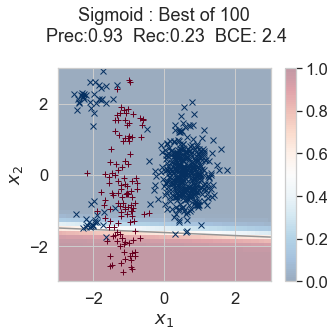

In [56]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_result__sigm['w_D'], x_ND, y_N,
    title_str='Sigmoid : Best of %d' % len(ranked_answers__sigm),
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

plt.tight_layout()
plt.savefig(os.path.join("images", "sigmoid_solution_precision_90.png"))

## Eban et al's Hinge surrogate loss


In [45]:
n_inits = 20
n_lam_values = 20

best_w_D__hin_by_lam = {}
best_loss__hin_by_lam = {}
answers__hin_by_lam = {}

for lamb in hin__lamb_candidate_values:
    print("")
    print("Lambda %.3g" % lamb)
    print("-----------")
    hin_loss, hin_grad, hin_tp, hin_fp = SurrogateHinge.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001)
    
    best_w_D__hin_by_lam[lamb], best_loss__hin_by_lam[lamb], _, answers__hin_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, hin_loss, hin_grad,
            calc_FPUB=hin_fp,
            calc_TPLB=hin_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True, alpha=alpha, lamb=lamb)


Lambda 1e-05
-----------
init 00   -1.81  -2.22  -1.61 | loss     -0.21047 final w   -3.24  -0.31  -0.48 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 120.0 FP<= 363.4
  surrogate  f     -120.00000  g   3150.26652  l2   0.00011
init 01   -2.45   2.08   1.71 | loss     -0.21046 final w   -1.38  -0.09   0.31 | recall 1.00 prec 0.53
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP = 108.0
  surrogate TP   >= 120.0 FP<= 412.0
  surrogate  f     -120.00000  g   3587.85309  l2   0.00002
init 02    1.91   0.30  -1.61 | loss     -0.21041 final w   -1.91  -0.86   1.39 | recall 1.00 prec 0.29
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP = 299.0
  surrogate TP   >= 120.0 FP<= 776.7
  surrogate  f     -120.00000  g   6870.59922  l2   0.00004
init 03    0.84  -0.52   1.81 | loss     -0.21036 final w   -0.16  -0.21   1.39 | recall 1.00 prec 0.21
meets constraint that prec >= 0.90 ?

init 10   -1.01   0.78   0.34 | loss     -0.21033 final w   -1.55  -0.10   0.22 | recall 1.00 prec 0.57
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  91.0
  surrogate TP   >= 120.0 FP<= 374.8
  surrogate  f     -120.00000  g   3253.36777  l2   0.00002
init 11   -0.03   1.36   1.82 | loss     -0.21010 final w   -0.47   0.15   0.96 | recall 1.00 prec 0.21
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP = 450.0
  surrogate TP   >= 120.0 FP<= 823.8
  surrogate  f     -120.00000  g   7294.51201  l2   0.00000
init 12    2.59  -1.83  -1.67 | loss     -0.21017 final w   -4.80  -1.79   1.00 | recall 1.00 prec 0.50
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP = 122.0
  surrogate TP   >= 120.0 FP<= 678.3
  surrogate  f     -120.00000  g   5985.05141  l2   0.00026
init 13    2.40  -0.56   2.19 | loss     -0.20986 final w    0.20  -0.22   1.79 | recall 1.00 prec 0.21
meets constraint that prec >= 0.90 ? NO
       true TP    = 12

init 00   -1.81  -2.22  -1.61 | loss     -0.20870 final w   -2.20  -0.14  -0.10 | recall 1.00 prec 0.66
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  61.0
  surrogate TP   >= 120.0 FP<= 317.9
  surrogate  f     -120.00000  g   2740.90605  l2   0.00005
init 01   -2.45   2.08   1.71 | loss     -0.20827 final w   -2.02  -0.01  -0.20 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 119.7 FP<= 292.1
  surrogate  f     -119.66745  g   2509.01683  l2   0.00004
init 02    1.91   0.30  -1.61 | loss     -0.20860 final w   -2.80  -0.17  -0.38 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 120.0 FP<= 334.3
  surrogate  f     -120.00000  g   2888.94951  l2   0.00008
init 03    0.84  -0.52   1.81 | loss     -0.20871 final w   -2.28  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 12

init 10   -1.01   0.78   0.34 | loss     -0.20441 final w   -2.30  -0.15  -0.15 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 317.3
  surrogate  f     -119.99945  g   2735.63866  l2   0.00005
init 11   -0.03   1.36   1.82 | loss     -0.20441 final w   -2.30  -0.15  -0.16 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 316.8
  surrogate  f     -119.99315  g   2731.16478  l2   0.00005
init 12    2.59  -1.83  -1.67 | loss     -0.20441 final w   -2.27  -0.14  -0.15 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 315.9
  surrogate  f     -119.98340  g   2723.54374  l2   0.00005
init 13    2.40  -0.56   2.19 | loss     -0.20440 final w   -2.25  -0.13  -0.16 | recall 1.00 prec 0.67
meets constraint that prec >= 0.90 ? NO
       true TP    = 12

init 01   -2.45   2.08   1.71 | loss     -0.15553 final w   -1.67  -0.06  -0.49 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  54.0
  surrogate TP   >= 115.1 FP<= 217.4
  surrogate  f     -115.14440  g   1841.66081  l2   0.00003
init 02    1.91   0.30  -1.61 | loss     -0.15553 final w   -1.67  -0.06  -0.49 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  54.0
  surrogate TP   >= 115.1 FP<= 217.4
  surrogate  f     -115.13716  g   1841.15647  l2   0.00003
init 03    0.84  -0.52   1.81 | loss     -0.15553 final w   -1.67  -0.06  -0.49 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  54.0
  surrogate TP   >= 115.1 FP<= 217.4
  surrogate  f     -115.14250  g   1841.53215  l2   0.00003
init 04    0.34  -0.45   2.69 | loss     -0.15553 final w   -1.68  -0.06  -0.48 | recall 1.00 prec 0.69
meets constraint that prec >= 0.90 ? NO
       true TP    = 12

init 11   -0.03   1.36   1.82 | loss     -0.05541 final w   -1.54  -0.16  -0.65 | recall 1.00 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  51.0
  surrogate TP   >= 105.5 FP<= 181.7
  surrogate  f     -105.50589  g   1529.53192  l2   0.00002
init 12    2.59  -1.83  -1.67 | loss     -0.05541 final w   -1.53  -0.16  -0.65 | recall 1.00 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  51.0
  surrogate TP   >= 105.4 FP<= 181.5
  surrogate  f     -105.44068  g   1528.17042  l2   0.00002
init 13    2.40  -0.56   2.19 | loss     -0.05541 final w   -1.53  -0.16  -0.65 | recall 1.00 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP    = 120.0 FP =  51.0
  surrogate TP   >= 105.4 FP<= 181.5
  surrogate  f     -105.43780  g   1528.11074  l2   0.00002
init 14    0.67  -1.66  -2.45 | loss     -0.05541 final w   -1.53  -0.16  -0.65 | recall 1.00 prec 0.70
meets constraint that prec >= 0.90 ? NO
       true TP    = 12

init 01   -2.45   2.08   1.71 | loss      0.32538 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 02    1.91   0.30  -1.61 | loss      0.32538 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 03    0.84  -0.52   1.81 | loss      0.32538 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00001  l2   0.00000
init 04    0.34  -0.45   2.69 | loss      0.32538 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 11   -0.03   1.36   1.82 | loss      0.59642 final w    0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 12    2.59  -1.83  -1.67 | loss      0.59642 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 13    2.40  -0.56   2.19 | loss      0.59642 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 14    0.67  -1.66  -2.45 | loss      0.59642 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 01   -2.45   2.08   1.71 | loss      4.56661 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00003  g   120.00003  l2   0.00000
init 02    1.91   0.30  -1.61 | loss      4.56661 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 03    0.84  -0.52   1.81 | loss      4.56661 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 04    0.34  -0.45   2.69 | loss      4.56661 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 11   -0.03   1.36   1.82 | loss     14.84616 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 12    2.59  -1.83  -1.67 | loss     14.84617 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00001  g   120.00001  l2   0.00000
init 13    2.40  -0.56   2.19 | loss     14.84617 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00001  g   120.00001  l2   0.00000
init 14    0.67  -1.66  -2.45 | loss     14.84616 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 01   -2.45   2.08   1.71 | loss    165.42316 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00001  g   120.00001  l2   0.00000
init 02    1.91   0.30  -1.61 | loss    165.42315 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 03    0.84  -0.52   1.81 | loss    165.42315 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 04    0.34  -0.45   2.69 | loss    165.42315 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 11   -0.03   1.36   1.82 | loss    555.29493 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 12    2.59  -1.83  -1.67 | loss    555.29494 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 13    2.40  -0.56   2.19 | loss    555.29493 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 14    0.67  -1.66  -2.45 | loss    555.29493 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 01   -2.45   2.08   1.71 | loss   6266.21363 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 02    1.91   0.30  -1.61 | loss   6266.21373 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 03    0.84  -0.52   1.81 | loss   6266.21383 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00001  l2   0.00000
init 04    0.34  -0.45   2.69 | loss   6266.21358 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

init 11   -0.03   1.36   1.82 | loss  21052.84217 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 12    2.59  -1.83  -1.67 | loss  21052.84223 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 13    2.40  -0.56   2.19 | loss  21052.84534 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00002  g   120.00002  l2   0.00000
init 14    0.67  -1.66  -2.45 | loss  21052.84239 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.90 ? NO
       true TP    =   0.0

In [47]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__hin = sorted(itertools.chain(*answers__hin_by_lam.values()),
    key=calc_common_loss_from_ans_dict,
    reverse=False)

best_result__hin = ranked_answers__hin[0]

In [48]:
best_result__hin

{'w_D': array([-0.87605323, -0.60598615, -1.12008426]),
 'loss': 0.14347579277606665,
 'is_sat': 0.0,
 'f': -12.644486709949966,
 'g': 581.518844102919,
 'l2': 1.1346884750943257e-05,
 'lamb': 0.1623776739188721,
 'init_id': 10,
 'precision': 0.7938144329888723,
 'recall': 0.6416666666661319,
 'TP': 77,
 'TN': 430,
 'FP': 20,
 'FN': 43}

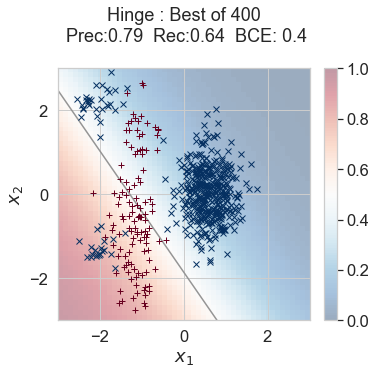

In [50]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(best_result__hin['w_D'], x_ND, y_N,
                                                       title_str='Hinge : Best of %d' % len(ranked_answers__hin),
                                                       x1_ticks=[-2, 0, 2],
                                                       x2_ticks=[-2, 0, 2],
                                                       G=51, H=51, figsize=figsize);

plt.savefig(os.path.join("images", "hinge_solution_precision_90.png"))

## Fathony et al's adversarial prediction

In [23]:
recall_gv_precision_90 = RecallGvPrecision(0.9)
recall_gv_precision_90.initialize()
recall_gv_precision_90.enforce_special_case_positive()
recall_gv_precision_90.set_cs_special_case_positive(True)

# performance metric
pm = recall_gv_precision_90


# ds = "whitewine"
# X_tr, X_ts, y_tr, y_ts = load_data(ds, standardize=True)

trainset = TabularDataset(x_ND, y_N)


batch_size = len(x_ND) # full batch
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

method = "ap-perf"              # uncomment if we want to use ap-perf objective 
# method = "bce-loss"           # uncomment if we want to use bce-loss objective

torch.manual_seed(46364)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

nvar = x_ND.shape[1]
model = LinearClassifier(nvar).to(device)

if method == "ap-perf":
    criterion = MetricLayer(pm).to(device)
    lr = 0.0006
    weight_decay = 0
else:
    criterion = nn.BCEWithLogitsLoss().to(device)
    lr = 1e-2
    weight_decay = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(11): # epoch 11 was the best checkpoint after running 50 epochs

    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
    # evaluate after each epoch
    model.eval()

    # train
    train_data = torch.tensor(x_ND).to(device)
    tr_output = model(train_data)
    tr_pred = (tr_output >= 0.0).float()
    tr_pred_np = tr_pred.cpu().numpy()
    
    train_acc = np.sum(y_N == tr_pred_np) / len(y_N)
    train_metric = pm.compute_metric(tr_pred_np, y_N)
    train_constraint = pm.compute_constraints(tr_pred_np, y_N)
    
    
    model.train()
    
    print('#{} loss : {:.2f} | Acc tr: {:.5f} | Metric tr: {:.5f} | Constraint tr: {:.5f}'.format(
        epoch, loss.detach().numpy()[0], train_acc, train_metric, train_constraint[0]))
    
opt_w_D_adversarial_90 = np.zeros(3)
opt_w_D_adversarial_90[:2] = list(model.parameters())[0].data[0]
opt_w_D_adversarial_90[2] = list(model.parameters())[1].data[0]

#0 loss : 37.97 | Acc tr: 0.84912 | Metric tr: 0.98333 | Constraint tr: 0.58416
#1 loss : 25.59 | Acc tr: 0.85789 | Metric tr: 0.90833 | Constraint tr: 0.60894
#2 loss : 16.59 | Acc tr: 0.86667 | Metric tr: 0.79167 | Constraint tr: 0.65068
#3 loss : 11.42 | Acc tr: 0.88070 | Metric tr: 0.75833 | Constraint tr: 0.70000
#4 loss : 8.73 | Acc tr: 0.88772 | Metric tr: 0.75833 | Constraint tr: 0.72222
#5 loss : 6.36 | Acc tr: 0.87544 | Metric tr: 0.70000 | Constraint tr: 0.70588
#6 loss : 4.39 | Acc tr: 0.82632 | Metric tr: 0.47500 | Constraint tr: 0.61290
#7 loss : 2.99 | Acc tr: 0.80877 | Metric tr: 0.46667 | Constraint tr: 0.55446
#8 loss : 2.38 | Acc tr: 0.83333 | Metric tr: 0.39167 | Constraint tr: 0.68116
#9 loss : 2.01 | Acc tr: 0.88596 | Metric tr: 0.87500 | Constraint tr: 0.67742
#10 loss : 2.96 | Acc tr: 0.81228 | Metric tr: 0.10833 | Constraint tr: 1.00000


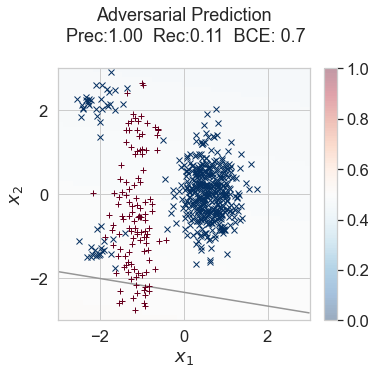

In [51]:
opt_w_D_adversarial_90 = ag_np.asarray([-0.0046, -0.0280, -0.0653])
perf, im, cbar = visuals.pretty_plot_decision_boundary(opt_w_D_adversarial_90, x_ND, y_N,
                                                       title_str='Adversarial Prediction',
                                                       x1_ticks=[-2, 0, 2],
                                                       x2_ticks=[-2, 0, 2],
                                                       G=51, H=51, figsize=figsize);

plt.savefig(os.path.join("images", "adversarial_prediction_precision_90.png"))

## Would the hinge loss prefer the solution from sigmoid loss?

No. The best result from the Sigmoid objective has way worse score under the Hinge's loss.

In [26]:
def calc_common_hinge_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = hin_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [27]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm)

2073778193.5786948

In [28]:
calc_common_hinge_loss_from_ans_dict(best_result__hin)

22345112.125233453

In [29]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm) < calc_common_hinge_loss_from_ans_dict(best_result__hin)

False

## Would the sigmoid loss prefer the solution from hinge?

No. The best result from the Hinge objective has way worse score under the Sigmoid's loss.

In [39]:
def calc_common_sigmoid_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = sigm_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [40]:
calc_common_sigmoid_loss_from_ans_dict(best_result__sigm)

-102.3499778078307

In [41]:
calc_common_sigmoid_loss_from_ans_dict(best_result__hin)

3892396.097734396

In [42]:
calc_common_sigmoid_loss_from_ans_dict(best_result__hin) < calc_common_sigmoid_loss_from_ans_dict(best_result__sigm)

False